In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tree
import os

from pathlib import Path
import xarray as xa
from jax import numpy as np
from jax.numpy import sqrt
import numpy as onp
from began import apply_per_image_standardization
from xhistogram.xarray import histogram

from began import rotate, flip
from began import Encoder, Decoder, VQVAEModel, ResidualStack
from began import make_square_mask, make_flat_bins, apply_nmt_flat
import pymaster as nmt

try:
    import sonnet.v2 as snt
    tf.enable_v2_behavior()
except ImportError:
    import sonnet as snt

In [2]:
loaded = tf.saved_model.load("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_pol/pol-vqvae-1024")


In [3]:
data_dir = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data")
test_fpath = data_dir / "mhd_ntest-0300.cdf"
test_images = xa.open_dataarray(test_fpath).sel(pol=['q', 'u']).transpose('batch', ..., 'pol').values.astype(np.float32)
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .batch(10))

In [4]:
data_dir = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data")
test_fpath = data_dir / "mhd_cl_ntest-0300.cdf"
test_xr_cl = xa.open_dataarray(test_fpath)

In [5]:
test_dataset

<BatchDataset shapes: (None, 256, 256, 2), types: tf.float32>

In [11]:
nsamp = test_images.shape[0]
dims = ['batch', 'x', 'y', 'pol']    
coords = {
    'batch': np.arange(nsamp),
    'x': np.arange(256),
    'y': np.arange(256),
    'pol': ['q', 'u']
}

coords_test = {
    **coords
}
coords_test.update(batch=np.arange(test_images.shape[0]))
test_xr = xa.DataArray(test_images, coords=coords_test, dims=dims, name='test')

In [12]:
reco_xr = xa.DataArray(loaded.inference(test_images[:nsamp])['x_recon'], coords=coords, dims=dims, name='recon')

In [13]:
resi_xr = test_xr - reco_xr
resi_xr.name = 'Residuals'

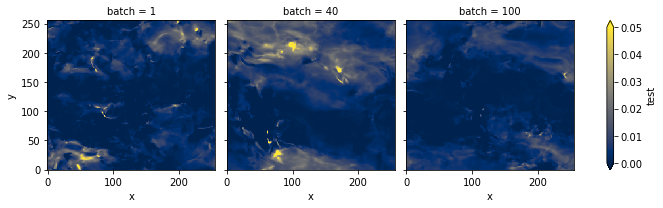

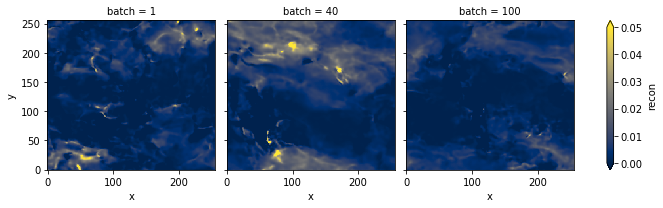

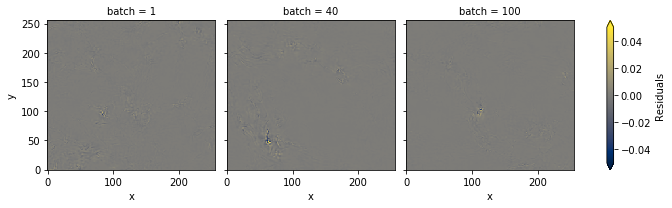

In [21]:
batch_idx = [1, 40, 100]
cmap = 'cividis'
vmin = 0
vmax = 0.05
test_xr.sel(batch=batch_idx, pol='q').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=vmin, vmax=vmax)
reco_xr.sel(batch=batch_idx, pol='q').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=vmin, vmax=vmax)
resi_xr.sel(batch=batch_idx, pol='q').plot.pcolormesh('x', 'y', col_wrap=3, col='batch', cmap=cmap, vmin=-0.05, vmax=0.05)

In [22]:
bins = onp.linspace(-0.01, 0.01, 50)
resi_xr_hist = histogram(resi_xr, bins=[bins], dim=['x', 'y']).sel(pol='q')
resi_xr_hist

<xarray.DataArray 'histogram_Residuals' (batch: 300, Residuals_bin: 49)>
array([[1, 0, 1, ..., 0, 2, 1],
       [4, 4, 6, ..., 2, 6, 1],
       [5, 3, 4, ..., 3, 2, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * batch          (batch) int32 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
    pol            <U1 'q'
  * Residuals_bin  (Residuals_bin) float64 -0.009796 -0.009388 ... 0.009796

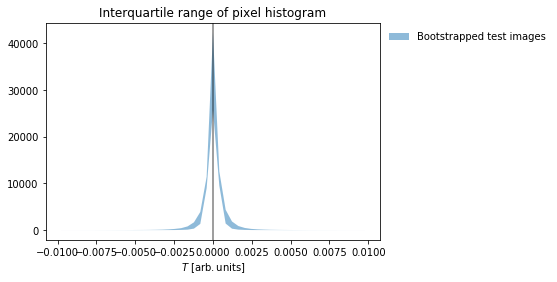

In [23]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(resi_xr_hist.Residuals_bin, resi_xr_hist.quantile(0.25, 'batch'), resi_xr_hist.quantile(0.75, 'batch'), label='Bootstrapped test images', alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
ax.set_label(r"Density")
ax.set_xlabel(r"$T~{\rm [arb. units]}$")
ax.set_title("Interquartile range of pixel histogram")
ax.axvline(x=0, color='k', alpha=0.5)

In [24]:
bins = onp.linspace(vmin, vmax, 100)
test_xr_hist = histogram(test_xr.sel(pol='q'), bins=[bins], dim=['x', 'y'])
reco_xr_hist = histogram(reco_xr.sel(pol='q'), bins=[bins], dim=['x', 'y'])

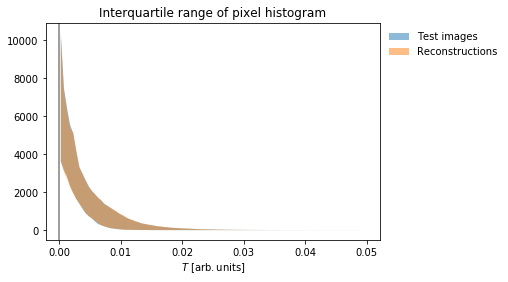

In [25]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(reco_xr_hist.recon_bin, reco_xr_hist.quantile(0.25, 'batch'), reco_xr_hist.quantile(0.75, 'batch'), label='Test images', alpha=0.5)
ax.fill_between(test_xr_hist.test_bin, test_xr_hist.quantile(0.25, 'batch'), test_xr_hist.quantile(0.75, 'batch'), label='Reconstructions', alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
ax.set_label(r"Density")
ax.set_xlabel(r"$T~{\rm [arb. units]}$")
ax.set_title("Interquartile range of pixel histogram")
ax.axvline(x=0, color='k', alpha=0.5)

In [27]:
nx = 256
ny = 256
theta = 29.
ang = onp.radians(theta)
mask = make_square_mask(nx, ny, ang)
binning = make_flat_bins(ang, nx, 8)

wsp22 = nmt.NmtWorkspaceFlat()

f2 = nmt.NmtFieldFlat(ang, ang, mask, onp.random.randn(2, nx, nx), purify_b=True, purify_e=True)

wsp22.compute_coupling_matrix(f2, f2, binning)

reco_xr_cl = apply_nmt_flat(reco_xr, mask, ang, binning, wsp22=wsp22)
reco_xr_cl_mean = reco_xr_cl.mean(dim='batch')
reco_xr_cl_std = reco_xr_cl.std(dim='batch')

Text(0.5, 0, '$\\ell_b$')

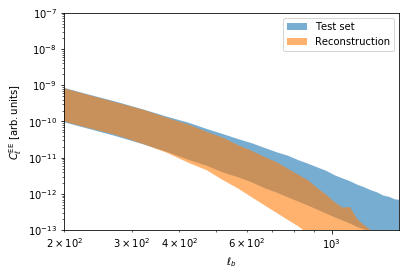

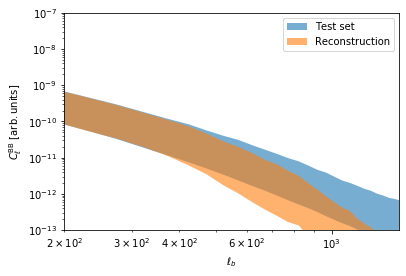

In [28]:
test_quantiles = test_xr_cl.quantile([0.25, 0.75], 'batch').sel(field='ee')
recon_quantiles = reco_xr_cl.quantile([0.27, 0.75], 'batch').sel(field='ee')
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_quantiles.bandpowers, test_quantiles.isel(quantile=0), test_quantiles.isel(quantile=1), alpha=0.6, label='Test set')
ax.fill_between(recon_quantiles.bandpowers, recon_quantiles.isel(quantile=0), recon_quantiles.isel(quantile=1), alpha=0.6, label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-13, 1e-7)
ax.set_xlim(200, 1500)
ax.set_ylabel(r'$C_\ell^{\rm EE}~[{\rm arb. units}]$')
ax.set_xlabel(r'$\ell_b$')

test_quantiles = test_xr_cl.quantile([0.25, 0.75], 'batch').sel(field='bb')
recon_quantiles = reco_xr_cl.quantile([0.27, 0.75], 'batch').sel(field='bb')
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_quantiles.bandpowers, test_quantiles.isel(quantile=0), test_quantiles.isel(quantile=1), alpha=0.6, label='Test set')
ax.fill_between(recon_quantiles.bandpowers, recon_quantiles.isel(quantile=0), recon_quantiles.isel(quantile=1), alpha=0.6, label='Reconstruction')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim(1e-13, 1e-7)
ax.set_xlim(200, 1500)
ax.set_ylabel(r'$C_\ell^{\rm BB}~[{\rm arb. units}]$')
ax.set_xlabel(r'$\ell_b$')

In [31]:
from jax import jit

In [51]:

def MF2D(image, threshold):
    height = image.shape[0]
    width = image.shape[1]
    
    f = 0.0
    u = 0.0
    chi = 0.0
    
    for y in np.arange(height-1):
        p10 = image[y, 0]
        p11 = image[y+1, 0]
        for x in np.arange(width-1):
            pattern = 0
            
            p00 = p10
            p01 = p11
            p10 = image[y, x+1]
            p11 = image[y+1, x+1]
            
            if p00 > threshold:
                pattern = pattern | 1
            if p10 > threshold:
                pattern = pattern | 2
            if p11 > threshold:
                pattern = pattern | 4
            if p01 > threshold:
                pattern = pattern | 8
                
            # a1 = (p00 - threshold) / (p00 - p10)
            # a2 = (p10 - threshold) / (p10 - p11)
            # a3 = (p01 - threshold) / (p01 - p11)
            # a4 = (p00 - threshold) / (p00 - p01)
            
            if pattern == 0:
                pass
            elif pattern == 1:
                a1 = (p00 - threshold) / (p00 - p10)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 0.5 * a1 * a4
                u += sqrt(a1*a1 + a4*a4)
                chi += 0.25
            elif pattern == 2:
                a1 = (p00 - threshold) / (p00 - p10)
                a2 = (p10 - threshold) / (p10 - p11)
                f += 0.5 * (1.0-a1)*a2
                u += sqrt((1.0-a1)*(1.0-a1) + a2*a2)
                chi += 0.25
            elif pattern == 3:
                a2 = (p10 - threshold) / (p10 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += a2 + 0.5*(a4-a2)
                u += sqrt(1.0 + (a4-a2)*(a4-a2))
            elif pattern == 4:
                a2 = (p10 - threshold) / (p10 - p11)
                a3 = (p01 - threshold) / (p01 - p11)
                f += 0.5 * (1.0-a2)*(1.0-a3)
                u += sqrt((1.0-a2)*(1.0-a2) + (1.0-a3)*(1.0-a3))
                chi += 0.25
            elif pattern == 5:
                a1 = (p00 - threshold) / (p00 - p10)
                a2 = (p10 - threshold) / (p10 - p11)
                a3 = (p01 - threshold) / (p01 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 1.0 - 0.5*(1.0-a1)*a2 - 0.5*a3*(1.0-a4)
                u += sqrt((1.0-a1)*(1.0-a1) + a2*a2) + sqrt(a3*a3 + (1.0-a4)*(1.0-a4))
                chi += 0.5
            elif pattern == 6:
                a1 = (p00 - threshold) / (p00 - p10)
                a3 = (p01 - threshold) / (p01 - p11)
                f += (1.0-a3) + 0.5*(a3-a1)
                u += sqrt(1.0 + (a3-a1)*(a3-a1))
            elif pattern == 7:
                a3 = (p01 - threshold) / (p01 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 1.0 - 0.5*a3*(1.0-a4)
                u += sqrt(a3*a3 + (1.0-a4)*(1.0-a4))
                chi += -0.25
            elif pattern == 8:
                a3 = (p01 - threshold) / (p01 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 0.5*a3*(1.0-a4)
                u += sqrt(a3*a3 + (1.0-a4)*(1.0-a4))
                chi += 0.25
            elif pattern == 9:
                a1 = (p00 - threshold) / (p00 - p10)
                a3 = (p01 - threshold) / (p01 - p11)
                f += a1 + 0.5*(a3-a1)
                u += sqrt(1.0 + (a3-a1)*(a3-a1))
            elif pattern == 10:
                a1 = (p00 - threshold) / (p00 - p10)
                a2 = (p10 - threshold) / (p10 - p11)
                a3 = (p01 - threshold) / (p01 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 1.0 - 0.5*a1*a4 + 0.5*(1.0-a2)*(1.0-a3)
                u += sqrt(a1*a1 + a4*a4) + sqrt((1.0-a2)*(1.0-a2) + (1.0-a3)*(1.0-a3))
                chi += 0.5
            elif pattern == 11:
                a2 = (p10 - threshold) / (p10 - p11)
                a3 = (p01 - threshold) / (p01 - p11)
                f += 1.0 - 0.5*(1.0-a2)*(1.0-a3)
                u += sqrt((1.0-a2)*(1.0-a2) + (1.0-a3)*(1.0-a3))
                chi += -0.25
            elif pattern == 12:
                a2 = (p10 - threshold) / (p10 - p11)
                a4 = (p00 - threshold) / (p00 - p01)
                f += (1.0-a2) + 0.5*(a2-a4)
                u += sqrt(1.0 + (a2-a4)*(a2-a4))
            elif pattern == 13:
                a1 = (p00 - threshold) / (p00 - p10)
                a2 = (p10 - threshold) / (p10 - p11)
                f += 1.0 - 0.5*(1.0-a1)*a2
                u += sqrt((1.0-a1)*(1.0-a1) + a2*a2)
                chi += -0.25
            elif pattern == 14:
                a1 = (p00 - threshold) / (p00 - p10)
                a4 = (p00 - threshold) / (p00 - p01)
                f += 1.0 - 0.5*a1*a4
                u += sqrt(a1*a1 + a4*a4)
                chi += -0.25
            elif pattern == 15:
                f += 1.0
    return (f, u, chi)

In [62]:
thresholds = np.linspace(-5, 5)
std_test_xr = apply_per_image_standardization(test_xr)
std_reco_xr = apply_per_image_standardization(reco_xr)

In [63]:
v0s = []
v1s = []
v2s = []
vr0s = []
vr1s = []
vr2s = []
for t in thresholds:
    v0, v1, v2 = MF2D(std_test_xr.values[0, 0, :, :], t)
    vr0, vr1, vr2 = MF2D(std_reco_xr.values[0, 0, :, :], t)

    v0s.append(v0)
    v1s.append(v1)
    v2s.append(v2)
    vr0s.append(vr0)
    vr1s.append(vr1)
    vr2s.append(vr2)

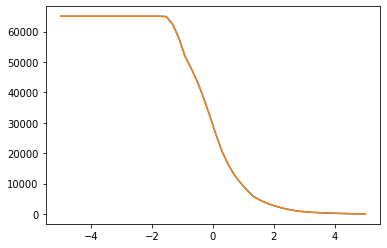

In [67]:
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, v0s)
ax.plot(thresholds, vr0s)

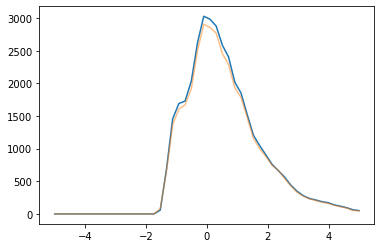

In [69]:
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, v1s)
ax.plot(thresholds, vr1s, alpha=0.5)

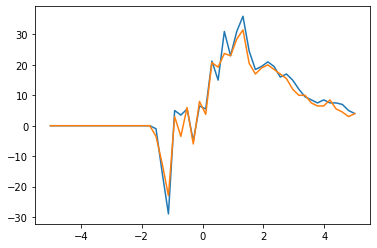

In [66]:
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, v2s)
ax.plot(thresholds, vr2s)